In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns

# Motivating KDE: Histograms

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

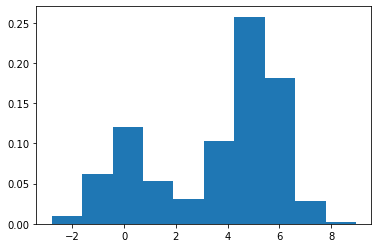

In [10]:
hist = graph.hist(x, density=True)
graph.show()

In [11]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

##### Choice of Bin size and location can change how we interpret drastically

In [12]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

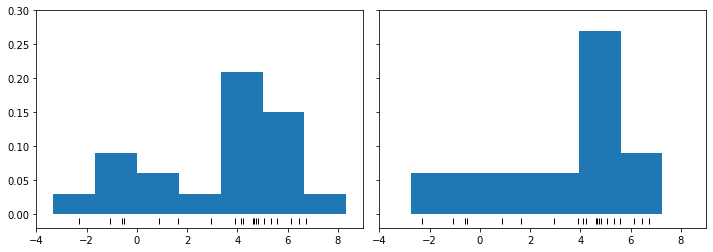

In [14]:
fig, ax = graph.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)
graph.show()

(-0.2, 8.0)

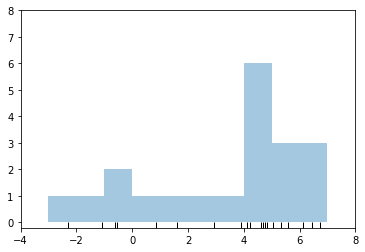

In [19]:
fig, ax = graph.subplots()
bins = np.arange(-3, 8)

ax.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth = 1)

for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(graph.Rectangle((edge, i), 1, 1, alpha=0.4))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

Stacking the blocks to the points they represent

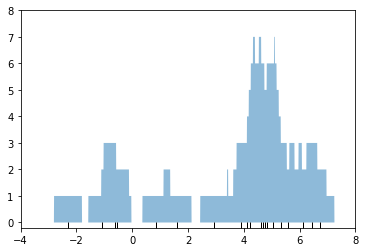

In [20]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

graph.fill_between(x_d, density, alpha=0.5)
graph.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

graph.axis([-4, 8, -0.2, 8])
graph.show()

##### Replace the blocks at each location with a smooth function, like a Gaussian

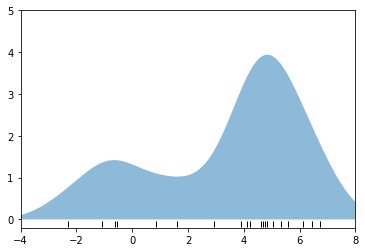

In [21]:
from scipy.stats import norm

x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

graph.fill_between(x_d, density, alpha=0.5)
graph.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

graph.axis([-4, 8, -0.2, 5])
graph.show()

# Kernel density estimation in practice

Free parameters are kde are:
- Kernel: specify the shape of the distribution placed at each point
- kernel bandwidth: control the size of kernel at each point

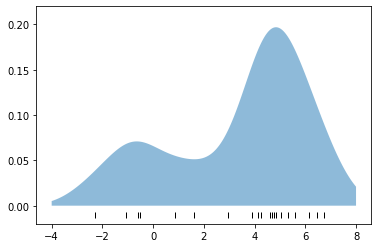

In [22]:
from sklearn.neighbors import KernelDensity

# instantiate and fit kde model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# Score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

graph.fill_between(x_d, np.exp(logprob), alpha=0.5)
graph.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
graph.ylim(-0.02, 0.22)

graph.show()

# Selecting the bandwidth via crossvalidation

- too narrow bandwidth: overfit, high variance estimate
- too wider bandwidth: underfit, low variance estimate

In [26]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None]);

In [27]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

# Example : KDE on a sphere

In [28]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

# Get matrices/arrays of species IDs and locations

latlon = np.vstack([data.train['dd lat'], 
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro') for d in data.train['species']], dtype='int')

/home/arshad/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.species_distributions module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


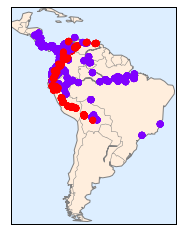

In [34]:
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids

xgrid, ygrid = construct_grids(data)

# plot coastlines with basemap
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())

m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
          c=species, cmap='rainbow', latlon=True)

Will use haversine distance metric, can correctly represent distances on a curved surface

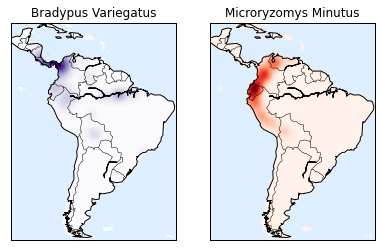

In [36]:
# Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Create two side-by-side plots
fig, ax = graph.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    
    # plot coastlines with basemap
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    # construct a spherical kernel density estimate of the distribution
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

# Example: Not-So-Naive Bayes

The general approach for generative classification is this:

1. Split the training data by label.

2. For each set, fit a KDE to obtain a generative model of the data. This allows you for any observation x and label y to compute a likelihood P(x | y).

3. From the number of examples of each class in the training set, compute the class prior, P(y).

4. For an unknown point x, the posterior probability for each class is P(y | x)∝P(x | y)P(y). The class which maximizes this posterior is the label assigned to the point.

In [37]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """ Bayesian generative classification based on KDE
    
    Parameters
    ----------------------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to kernel density
    """
    
    def __init__(self, bandwidth = 1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, x, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [x[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth = self.bandwidth, kernel = self.kernel).fit(xi) for xi in training_sets]
        self.logpriors_ = [np.log(xi.shape[0] / x.shape[0]) for xi in training_sets]
        return self
        
    def predict_proba(self, x):
        logprobs = np.array([model.score_samples(x) for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
    
    def predict(self, x):
        return self.classes_[np.argmax(self.predict_proba(x), 1)]

In [41]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

scores = grid.cv_results_['mean_test_score']

{'bandwidth': 6.135907273413174}
accuracy = 0.9677298050139276


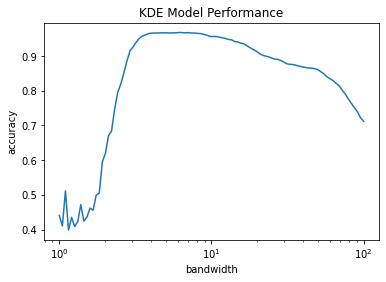

In [42]:
print(grid.best_params_)
print('accuracy =', grid.best_score_)

graph.title('KDE Model Performance')
graph.semilogx(bandwidths, scores)
graph.xlabel('bandwidth')
graph.ylabel('accuracy')
graph.show()

In [43]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), digits.data, digits.target).mean()

0.8069281956050759

In [47]:
test = list('stephenrose')

def func(input):
    for item in input:
        yield item

In [50]:
for item in enumerate(test):
    print(item)

(0, 's')
(1, 't')
(2, 'e')
(3, 'p')
(4, 'h')
(5, 'e')
(6, 'n')
(7, 'r')
(8, 'o')
(9, 's')
(10, 'e')


In [46]:
for item in test:
    print(item)

s
t
e
p
h
e
n
r
o
s
e
